
## Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.4.0


## Load and Inspect the Sens Index Data

In [2]:
df = pd.read_csv('/content/BSE30.csv' , parse_dates = ['date'])
df.head()

,date,close
0,1990-01-01,783.35
1,1990-01-02,780.01
2,1990-01-03,763.22
3,1990-01-04,760.80
4,1990-01-05,774.58


In [3]:
df.shape

(7425, 2)

In [4]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date , y = df.close , mode = 'lines' , name = 'close'))
fig.update_layout(showlegend = True)
fig.show()

## Data Preprocessing

In [5]:
train_size = int(len(df)*0.90)
test_size = len(df) - train_size 
train , test = df.iloc[0:train_size] , df.iloc[train_size:len(df)]
print(train.shape , test.shape)

(6682, 2) (743, 2)


In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler=scaler.fit(train[['close']])
train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

## Create Training and Test Splits

In [7]:
def create_sequences (X,y,time_step=30):
    Xs , ys = [],[]
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs) , np.array(ys)

In [8]:
time_steps = 30
X_train , y_train = create_sequences(train[['close']] , train.close , time_steps)
X_test , y_test = create_sequences(test[['close']] , test.close , time_steps)
print(X_train.shape)

(6652, 30, 1)


## Build an LSTM Autoencoder

In [9]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([LSTM(128 , input_shape=(timesteps , num_features)),Dropout(0.5),RepeatVector(timesteps),LSTM(128,return_sequences=True),Dropout(0.5),TimeDistributed(Dense(num_features))])

model.compile(loss='mae' , optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

## Train the Autoencoder

In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss' , patience = 3 , mode='min')
history = model.fit(X_train,y_train,epochs=10,batch_size=128,validation_split=0.20,callbacks=[es],shuffle=False)

Epoch 1/10
42/42 [==============================] - 10s 34ms/step - loss: 0.4031 - val_loss: 0.2998
Epoch 2/10
42/42 [==============================] - 0s 9ms/step - loss: 0.1830 - val_loss: 0.1935
Epoch 3/10
42/42 [==============================] - 0s 9ms/step - loss: 0.1257 - val_loss: 0.1719
Epoch 4/10
42/42 [==============================] - 0s 9ms/step - loss: 0.1118 - val_loss: 0.0907
Epoch 5/10
42/42 [==============================] - 0s 9ms/step - loss: 0.1026 - val_loss: 0.0833
Epoch 6/10
42/42 [==============================] - 1s 13ms/step - loss: 0.1147 - val_loss: 0.0779
Epoch 7/10
42/42 [==============================] - 0s 9ms/step - loss: 0.1309 - val_loss: 0.2749
Epoch 8/10
42/42 [==============================] - 0s 9ms/step - loss: 0.0879 - val_loss: 0.0824
Epoch 9/10
42/42 [==============================] - 0s 9ms/step - loss: 0.1243 - val_loss: 0.3157


## Plot Metrics and Evaluate the Model

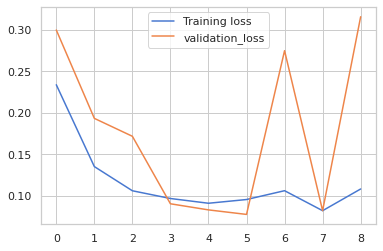

In [12]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='validation_loss')
plt.legend()

In [13]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred-X_train),axis = 1),columns = ['Error'])

In [14]:
model.evaluate(X_test,y_test)

23/23 [==============================] - 0s 3ms/step - loss: 0.5799


0.5798705220222473

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



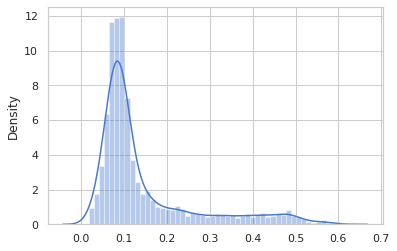

In [15]:
sns.distplot(train_mae_loss , bins = 50 , kde= True)

In [25]:
threshold = 0.7

In [26]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test),axis=1)

## Detect Anomalies in the Sensex Index Data

In [27]:
test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anamoly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [28]:
test_score_df.head()

,date,close,loss,threshold,anamoly
6712,2017-12-06,2.467744,0.495402,0.7,False
6713,2017-12-07,2.507377,0.479806,0.7,False
6714,2017-12-08,2.541274,0.480360,0.7,False
6715,2017-12-11,2.564409,0.490929,0.7,False
6716,2017-12-12,2.538763,0.508740,0.7,False


In [29]:
test_score_df.tail()

,date,close,loss,threshold,anamoly
7420,2020-10-19,3.349765,0.758396,0.7,True
7421,2020-10-20,3.362461,0.757141,0.7,True
7422,2020-10-21,3.380806,0.755329,0.7,True
7423,2020-10-22,3.364051,0.760718,0.7,True
7424,2020-10-23,3.378350,0.759878,0.7,True


In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = test[time_steps:].date, y = test_score_df.loss,mode='lines',name='Test_Loss'))
fig.add_trace(go.Scatter(x = test[time_steps:].date, y = test_score_df.threshold,mode='lines',name='Threshold'))
fig.update_layout(showlegend = True)
fig.show()

In [31]:
anomalies = test_score_df[test_score_df.anamoly == True]
anomalies

,date,close,loss,threshold,anamoly
6746,2018-01-24,2.869041,0.704046,0.7,True
6747,2018-01-25,2.856522,0.715470,0.7,True
6748,2018-01-29,2.882732,0.718683,0.7,True
6749,2018-01-30,2.854641,0.725500,0.7,True
6750,2018-01-31,2.846905,0.719627,0.7,True
...,...,...,...,...,...
7420,2020-10-19,3.349765,0.758396,0.7,True
7421,2020-10-20,3.362461,0.757141,0.7,True
7422,2020-10-21,3.380806,0.755329,0.7,True
7423,2020-10-22,3.364051,0.760718,0.7,True


In [32]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = test[time_steps:].date, y = scaler.inverse_transform(test[time_steps:].close),mode='lines',name='Close Price'))
fig.add_trace(go.Scatter(x = anomalies.date, y = scaler.inverse_transform(anomalies.close),mode='markers',name='Anomalies'))
fig.update_layout(showlegend = True)
fig.show()